In [1]:
#import sys
#!{sys.executable} -m pip install torch
import numpy as np

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision # datasets & pretrained nets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
import math

def plot_indices(data, indices):
    
    #dimensions of the picture
    x_dim = min(len(indices), 20)
    y_dim = math.ceil(len(indices)/20)
    fig, axs = plt.subplots(y_dim, x_dim, figsize=(x_dim,y_dim ))
    
    # no axes and ticks etc    
    [axi.set_axis_off() for axi in axs.ravel()]
    
    # loop and plot
    axs = axs.flatten()
    for i, ax in zip(indices, axs):
        tensor_image, label = data[i] 
        # channels need to be switched for plt to understand pytorch
        ax.imshow(tensor_image.permute(1, 2, 0), cmap="gray")
    plt.show()

In [3]:
# check if torch finds the GPU
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

# check "gpustat -i 1" in terminal to see GPU action

'NVIDIA GeForce MX150'

## Neural Nets

### Fully Connected (MNIST) 

In [4]:
# Transform the data to torch tensors and normalize it 
transform_mnist = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307), ((0.3081)))])
# Prepare training set and testing set
trainset_mnist = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform_mnist)
testset_mnist = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform_mnist)

# Prepare training loader and testing loader
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=32, shuffle=True, num_workers=4)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=32, shuffle=False, num_workers=4)
print(trainloader_mnist.dataset.data.shape, testloader_mnist.dataset.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


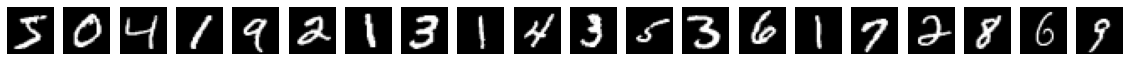

In [5]:
plot_indices(data=trainset_mnist, indices=range(20))

#### Define the net

In [6]:
# Define the class Net
class Net_mnist(nn.Module):
    def __init__(self):    
        # Define all the parameters of the net
        super(Net_mnist, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):    
        # Do the forward pass
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### train

In [7]:
%%time
# Instantiate the network, the Adam optimizer and Cross-Entropy loss function
model_mnist = Net_mnist().cuda()   
optimizer = optim.Adam(model_mnist.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

for batch_idx, data_target in enumerate(trainloader_mnist):
    data = data_target[0].cuda()
    target = data_target[1].cuda()
    data = data.view(-1, 28 * 28 * 1)
    optimizer.zero_grad()

    # Complete a forward pass
    output = model_mnist(data)

    # Compute the loss, gradients and change the weights
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

CPU times: user 7.38 s, sys: 1.72 s, total: 9.09 s
Wall time: 10.8 s


#### evaluate

In [8]:
correct, total = 0, 0
predictions = []
# Set the model in eval mode
model_mnist.eval()

for i, data in enumerate(testloader_mnist, 0):
    #inputs, labels = data
    inputs = data[0].cuda()
    labels = data[1].cuda()
    
    # Put each image into a vector
    inputs = inputs.view(-1, 28 * 28)
    
    # Do the forward pass and get the predictions
    outputs = model_mnist(inputs)
    _, outputs = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (outputs == labels).sum().item()
print('The test set accuracy of the network is: %d %%' % (100 * correct / total))

The test set accuracy of the network is: 95 %


### CNN (CIFAR10)

In [9]:
# Standardize with mean and std
transform_cifar10 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.48216, 0.44653),
                                                                            (0.24703, 0.24349, 0.26159))])
# download the sets
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
testset_cifar10 =  torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_cifar10)
# batches to read in
indices = np.arange(50000)
np.random.shuffle(indices)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=64, shuffle=False, num_workers=4,
                                              sampler=torch.utils.data.SubsetRandomSampler(indices[:45000]))
validationloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=64, shuffle=False, num_workers=4,
                                              sampler=torch.utils.data.SubsetRandomSampler(indices[45000:50000]))
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=64, shuffle=False, num_workers=4)
print(trainloader_cifar10.dataset.data.shape, testloader_cifar10.dataset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3) (10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

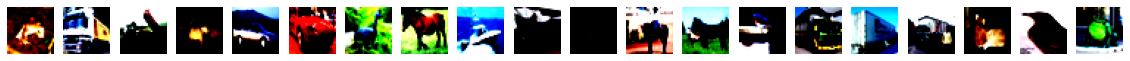

In [10]:
plot_indices(data=trainset_cifar10, indices=range(20))

#### Define the net

In [11]:
# Define the class Net
class Net_cifar10(nn.Module):
    def __init__(self, num_classes=10):
        super(Net_cifar10, self).__init__()
        
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # rgb:3; convolutions:5, kernel:3x3; stride:1; padding:1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Instantiate a fully connected layer
        self.fc = nn.Linear(4 * 4 * 128, num_classes)
        
    
    def forward(self, x):
  
        # Apply conv followed by relu, then pool
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Prepare the image for the fully connected layer
        x = x.view(-1, 4 * 4 * 128)

        # Apply the fully connected layer and return the result
        return self.fc(x)


In [12]:
# alternative method using sequential (exact same net)
class Net_cifar10(nn.Module):
    def __init__(self):
        super(Net_cifar10, self).__init__()
        
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), 
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(2, 2), # nn.BatchNorm2d(10),
                                      nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1), 
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(2, 2), # nn.BatchNorm2d(10),
                                      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(2, 2)) #, nn.BatchNorm2d(10)) 
        
        # Declare all the layers for classification
        self.classifier = nn.Sequential(nn.Linear(4 * 4 * 128, 10)) # we could add dropout: nn.Dropout(p=0.2)
        
    def forward(self, x):
      
        # Apply the feature extractor in the input
        x = self.features(x)
        
        # Squeeze the three spatial dimensions in one
        x = x.view(-1, 4 * 4 * 128)
        
        # Classify the images
        x = self.classifier(x)
        return x

#### learn

In [13]:
%%time
# Instantiate the network, the Adam optimizer and Cross-Entropy loss function
model_cifar10 = Net_cifar10().cuda()  

optimizer = optim.Adam(model_cifar10.parameters(), lr=3e-4) # version of gradient descent, 
#add: weight_decay=0.0001 in order to introduce L2

criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    for batch_idx, data_target in enumerate(trainloader_cifar10):
        data = data_target[0].cuda()
        target = data_target[1].cuda()
        
        optimizer.zero_grad() # do not accumulate gradients from the previous iterations

        # Complete a forward pass
        output = model_cifar10(data)

        # Compute the loss, gradients and change the weights
        loss = criterion(output, target) #forward
        loss.backward() #backward
        optimizer.step() #optimize

CPU times: user 1min 11s, sys: 7.32 s, total: 1min 18s
Wall time: 1min 21s


#### evaluate

In [14]:
correct, total = 0, 0
predictions = []
# Set the model in eval mode
model_cifar10.eval()

for i, data in enumerate(testloader_cifar10, 0):
    #inputs, labels = data
    inputs = data[0].cuda()
    labels = data[1].cuda()
    
    # Do the forward pass and get the predictions
    outputs = model_cifar10(inputs)
    _, outputs = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (outputs == labels).sum().item()
print('The test set accuracy of the network is: %d %%' % (100 * correct / total))

The test set accuracy of the network is: 71 %


### Finetuning existing neural networks

In [15]:
model_resnet18 = torchvision.models.resnet18()

# Freeze all the layers bar the last one
for param in model_resnet18.parameters():
    param.requires_grad = False
    
# Change the number of output units
model_resnet18.fc = nn.Linear(512, 7)

## Prototypes and Criticisms

no need for a neural network

In [16]:
# code to original paper
from mmdcriticmaster.mmd import select_criticism_regularized, greedy_select_protos

from torch.utils.data import default_collate
from sklearn.metrics.pairwise import rbf_kernel

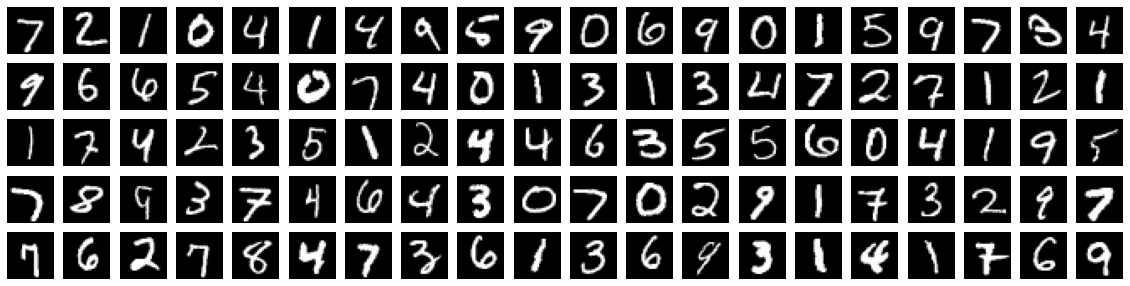

In [24]:
# data
plot_indices(data=testset_mnist, indices=range(100))

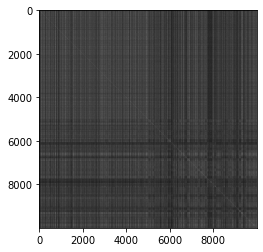

In [25]:
# create kernel density of data

# create feature matrix: #pictures x #pixels
X, y = default_collate(list(testset_mnist))
X = X.reshape(10000, 784).numpy() 

#get RBF kernel density
K = rbf_kernel(X, gamma=None)
# plot kernel density
plt.imshow(K, cmap="gray")
plt.show()

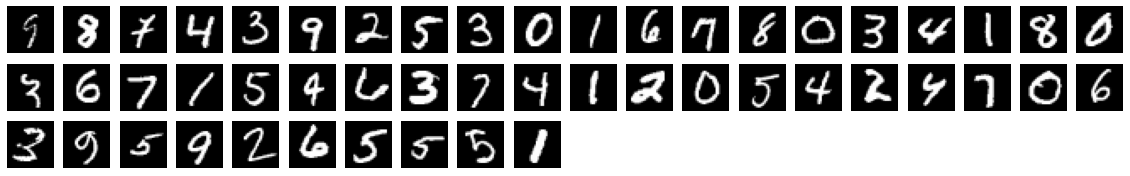

In [26]:
# prototypes

# Function choose m of all rows by MMD as per kernelfunc
# ARGS:
# K : kernel matrix
# candidate_indices : array of potential choices for selections, returned values are chosen from these  indices
# m: number of selections to be made
# is_K_sparse:  True means K is the pre-computed  csc sparse matrix? False means it is a dense matrix.
# RETURNS: subset of candidate_indices which are selected as prototypes
selectedprotos = greedy_select_protos(K, np.asarray(list(range(10000))), m=50, is_K_sparse=False)
plot_indices(data=testset_mnist, indices=selectedprotos)

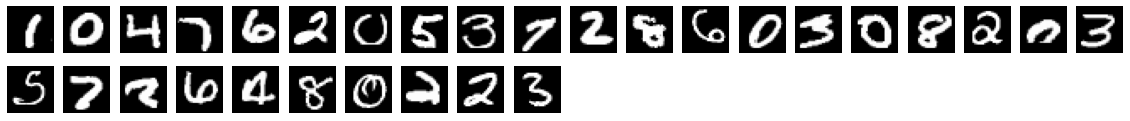

In [27]:
#criticisms

# function to select criticisms
# ARGS:
# K: Kernel matrix
# selectedprotos: prototypes already selected
# m : number of criticisms to be selected
# reg: regularizer type.
# is_K_sparse:  True means K is the pre-computed  csc sparse matrix? False means it is a dense matrix.
# RETURNS: indices selected as criticisms
criticisms = select_criticism_regularized(K, list(selectedprotos), m=30, reg='logdet', is_K_sparse=False)
plot_indices(data=testset_mnist, indices=criticisms)